In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Activation, Dropout
from keras.optimizers import SGD
from keras.models import Model, Sequential
import keras
import tensorflow as tf
import keras.backend as K
import numpy as np
import os
import sys

In [157]:
class SGDL(SGD):
    """Stochastic gradient descent Langevian optimizer.

    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    x_next = get_x_next_SGD(x) + gamma * W, where W is gaussian same shape as weight
    # Arguments
        gamma: float >= 0 initial gaussian update weight
    """

    def __init__(self, gamma=0.1, **kwargs):
        super(SGDL, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.gamma = K.variable(gamma, name="gamma")
        print(K.int_shape(self.iterations))

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        gamma = self.gamma * (1. / (1. + K.cast(self.iterations, tf.float32)))

        # momentum
        shapes = [K.int_shape(p) for p in params]
        gaussians = [K.random_normal(shape) for shape in shapes]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m, W in zip(params, grads, moments, gaussians):
            v = self.momentum * m - lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p + v
            new_p = new_p + gamma * W

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

# Exploration of SGD convergence to sharp and flat minimas

In [249]:
def f_osipov(x_vec):
    """function created by Nick Osipov specially for our research"""
    x = x_vec[0]
    y = x_vec[1]
    return  (0.1 * (x-4) ** 2-1) * 2 ** (-(x-4) ** 2) + (0.1 * (x-8)**2 + 0.1 * (y-5)**2 -1) *2 **(-((x-8)**2+(y-5)**2))

def f_rosenbroke(x_vec):
    x, y = x_vec[0], x_vec[1]
    return (1-x)**2 + 100*(y-x**2)**2

def sgd(f, x0, n_iters=1000, grad_f=None, lr=1e-3, gamma=0, gamma_k=None):
    """sgd (langevian) optimization algorithm"""
    if grad_f is None:
        eps = 1e-5
        grad_f = lambda x: (f(x+eps)-f(x)) / eps
    if gamma_k is None:
        gamma_k = lambda k, gamma: 1. / (1. + k) * gamma
    
    x = x0
    for k in range(n_iters):
        x = x - lr * grad_f(x) + gamma_k(k, gamma) * np.random.normal(size=x.shape)
    return x, f(x)

x0 = np.random.uniform(10, size=(2,))
sgd(f_osipov, x0)

(array([4.08761308, 1.71644193]), -0.9939299413914614)

In [250]:
def calc_weights(f_vec, n_iters=100, x0_heigh=10, **sgd_kwargs):
    weights = np.zeros((n_iters, 2))
    for i in range(n_iters):
        x0 = np.random.uniform(x0_heigh, size=(2,))
        w, f = sgd(f_vec, x0, **sgd_kwargs)
        weights[i] = w
    return weights

def calc_weights_per_gamma(f_vec, n_iters=1000, x0_heigh=10, gammas=[0, 0.1, 0.01, 0.001]):
    weights = dict()
    for gamma in gammas:
        print(f'gamma={gamma}')
        weights[gamma] = calc_weights(f_vec, n_iters=n_iters, x0_heigh=x0_heigh, gamma=gamma)
    return weights

In [253]:
%%time

weights_f_osipov = calc_weights_per_gamma(f_osipov, x0_heigh=10, n_iters=10000)
weights_f_rosenbroke = calc_weights_per_gamma(f_rosenbroke, x0_heigh=2, n_iters=10000)

gamma=0
gamma=0.1
gamma=0.01
gamma=0.001
gamma=0
gamma=0.1
gamma=0.01
gamma=0.001
CPU times: user 13min 24s, sys: 0 ns, total: 13min 24s
Wall time: 13min 21s


In [254]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(x, y, bins=30, range=[[0, 10], [0, 10]]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range)

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
    
def plot_weights(weights, bins=30, range=[[0, 10], [0, 10]]):
    plot3d(weights[:, 0], weights[:, 1], bins=bins, range=range)
    plt.title(f"gamma={gamma}")
    plt.show()

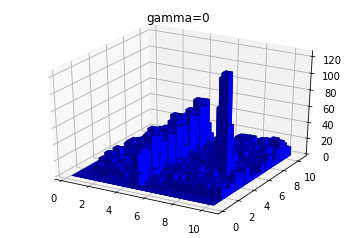

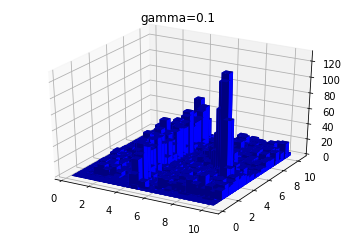

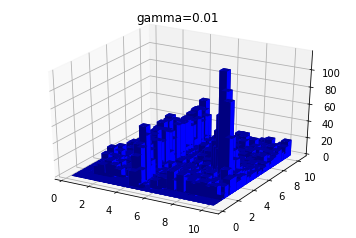

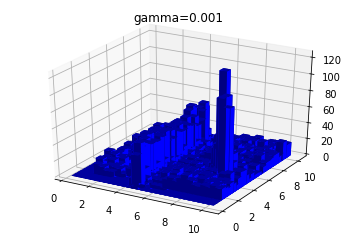

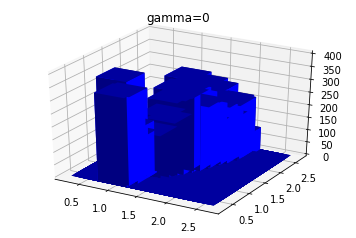

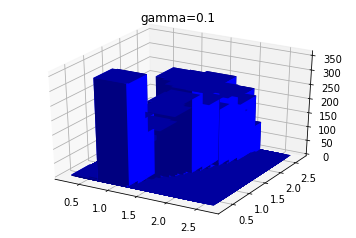

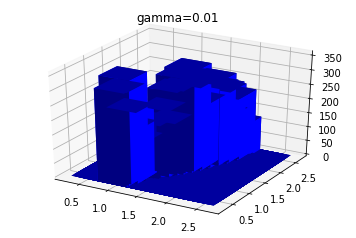

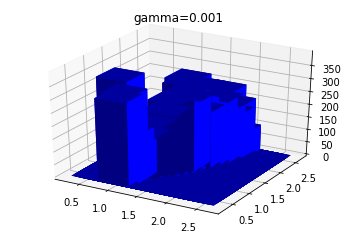

In [255]:
for gamma in weights_f_osipov.keys():
    plot_weights(weights_f_osipov[gamma], bins=30, range=[[0, 10], [0, 10]])

for gamma in weights_f_rosenbroke.keys():
    plot_weights(weights_f_rosenbroke[gamma], bins=30, range=[[0, 2], [0, 2]])

## MNIST training SGD & SGDL

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11493376/11490434 [==============================] - 12s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [55]:
def build_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Lambda(lambda x: x / 255.))
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                                  # of the layer above. Here, with a "rectified linear unit",
                                  # we clamp all values below 0 to 0.

    model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                     # ensures the output is a valid probaility distribution, that is
                                     # that its values are all non-negative and sum to 1.
    return model

model = build_model()
model.compile(optimizer=SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train,
          batch_size=32, epochs=3,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 75us/step - loss: 0.6451 - acc: 0.8236 - val_loss: 0.3002 - val_acc: 0.9153
Epoch 2/3
60000/60000 [==============================] - 4s 62us/step - loss: 0.3224 - acc: 0.9062 - val_loss: 0.2353 - val_acc: 0.9316
Epoch 3/3
60000/60000 [==============================] - 4s 62us/step - loss: 0.2588 - acc: 0.9252 - val_loss: 0.1950 - val_acc: 0.9451


In [72]:
os.makedirs('logs', exist_ok=True)
for gamma in [0, 0.1, 0.01, 0.001, 0.0001]:
    cb = keras.callbacks.CSVLogger(f'logs/SGDL_{gamma}.txt', separator=',')
    model = build_model()
    model.compile(optimizer=SGDL(gamma=gamma), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train,
              batch_size=32, epochs=100,
              verbose=1, callbacks=[cb],
              validation_data=(X_test, y_test))

()
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.5537 - acc: 0.8255 - val_loss: 0.2322 - val_acc: 0.9320
Epoch 2/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.2921 - acc: 0.9123 - val_loss: 0.1834 - val_acc: 0.9474
Epoch 3/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.2398 - acc: 0.9278 - val_loss: 0.1560 - val_acc: 0.9535
Epoch 4/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.2057 - acc: 0.9377 - val_loss: 0.1393 - val_acc: 0.9574
Epoch 5/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.1810 - acc: 0.9460 - val_loss: 0.1257 - val_acc: 0.9601
Epoch 6/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.1628 - acc: 0.9497 - val_loss: 0.1181 - val_acc: 0.9631
Epoch 7/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.1507 - acc: 0.9543 - val_loss: 0.1120

60000/60000 [==============================] - 4s 69us/step - loss: 0.0252 - acc: 0.9922 - val_loss: 0.0597 - val_acc: 0.9815
Epoch 60/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0251 - acc: 0.9919 - val_loss: 0.0605 - val_acc: 0.9823
Epoch 61/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.0605 - val_acc: 0.9819
Epoch 62/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0250 - acc: 0.9923 - val_loss: 0.0597 - val_acc: 0.9819
Epoch 63/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0234 - acc: 0.9925 - val_loss: 0.0600 - val_acc: 0.9822
Epoch 64/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0228 - acc: 0.9931 - val_loss: 0.0598 - val_acc: 0.9824
Epoch 65/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0232 - acc: 0.9932 - val_loss: 0.0602 - val_acc: 0.9818
Epoch 66/100
60000/60000 [==============

Epoch 18/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0799 - acc: 0.9746 - val_loss: 0.0761 - val_acc: 0.9760
Epoch 19/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0810 - acc: 0.9746 - val_loss: 0.0742 - val_acc: 0.9763
Epoch 20/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0748 - acc: 0.9762 - val_loss: 0.0728 - val_acc: 0.9768
Epoch 21/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0709 - acc: 0.9773 - val_loss: 0.0716 - val_acc: 0.9774
Epoch 22/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0681 - acc: 0.9783 - val_loss: 0.0711 - val_acc: 0.9776
Epoch 23/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0658 - acc: 0.9793 - val_loss: 0.0709 - val_acc: 0.9775
Epoch 24/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0637 - acc: 0.9795 - val_loss: 0.0686 - val_acc: 0.9785
Epoch 25/100
60000/60000 [=

Epoch 77/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0184 - acc: 0.9944 - val_loss: 0.0573 - val_acc: 0.9829
Epoch 78/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0581 - val_acc: 0.9831
Epoch 79/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0579 - val_acc: 0.9832
Epoch 80/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0165 - acc: 0.9951 - val_loss: 0.0567 - val_acc: 0.9829
Epoch 81/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.0571 - val_acc: 0.9832
Epoch 82/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0577 - val_acc: 0.9832
Epoch 83/100
60000/60000 [==============================] - 4s 69us/step - loss: 0.0172 - acc: 0.9949 - val_loss: 0.0573 - val_acc: 0.9834
Epoch 84/100
60000/60000 [=

60000/60000 [==============================] - 4s 70us/step - loss: 0.0475 - acc: 0.9848 - val_loss: 0.0642 - val_acc: 0.9802
Epoch 36/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0455 - acc: 0.9856 - val_loss: 0.0638 - val_acc: 0.9797
Epoch 37/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0445 - acc: 0.9857 - val_loss: 0.0618 - val_acc: 0.9813
Epoch 38/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0433 - acc: 0.9864 - val_loss: 0.0622 - val_acc: 0.9806
Epoch 39/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0415 - acc: 0.9867 - val_loss: 0.0621 - val_acc: 0.9811
Epoch 40/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0406 - acc: 0.9868 - val_loss: 0.0621 - val_acc: 0.9802
Epoch 41/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0409 - acc: 0.9869 - val_loss: 0.0611 - val_acc: 0.9817
Epoch 42/100
60000/60000 [==============

60000/60000 [==============================] - 4s 70us/step - loss: 0.0145 - acc: 0.9956 - val_loss: 0.0573 - val_acc: 0.9843
Epoch 95/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0141 - acc: 0.9958 - val_loss: 0.0576 - val_acc: 0.9834
Epoch 96/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0141 - acc: 0.9956 - val_loss: 0.0571 - val_acc: 0.9836
Epoch 97/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0576 - val_acc: 0.9839
Epoch 98/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0573 - val_acc: 0.9840
Epoch 99/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0137 - acc: 0.9959 - val_loss: 0.0582 - val_acc: 0.9841
Epoch 100/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0578 - val_acc: 0.9842
()
Train on 60000 samples, validate on 

Epoch 53/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0297 - acc: 0.9906 - val_loss: 0.0572 - val_acc: 0.9829
Epoch 54/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0289 - acc: 0.9915 - val_loss: 0.0564 - val_acc: 0.9822
Epoch 55/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0279 - acc: 0.9911 - val_loss: 0.0583 - val_acc: 0.9824
Epoch 56/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0279 - acc: 0.9912 - val_loss: 0.0563 - val_acc: 0.9822
Epoch 57/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0256 - acc: 0.9916 - val_loss: 0.0566 - val_acc: 0.9820
Epoch 58/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0262 - acc: 0.9917 - val_loss: 0.0569 - val_acc: 0.9828
Epoch 59/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0562 - val_acc: 0.9828
Epoch 60/100
60000/60000 [=

60000/60000 [==============================] - 4s 71us/step - loss: 0.1129 - acc: 0.9643 - val_loss: 0.0913 - val_acc: 0.9711
Epoch 12/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.1068 - acc: 0.9670 - val_loss: 0.0885 - val_acc: 0.9715
Epoch 13/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1004 - acc: 0.9699 - val_loss: 0.0866 - val_acc: 0.9726
Epoch 14/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0951 - acc: 0.9707 - val_loss: 0.0828 - val_acc: 0.9727
Epoch 15/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0909 - acc: 0.9718 - val_loss: 0.0808 - val_acc: 0.9736
Epoch 16/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0872 - acc: 0.9733 - val_loss: 0.0800 - val_acc: 0.9741
Epoch 17/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0815 - acc: 0.9754 - val_loss: 0.0769 - val_acc: 0.9756
Epoch 18/100
60000/60000 [==============

60000/60000 [==============================] - 4s 71us/step - loss: 0.0201 - acc: 0.9937 - val_loss: 0.0619 - val_acc: 0.9827
Epoch 71/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0616 - val_acc: 0.9824
Epoch 72/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0192 - acc: 0.9944 - val_loss: 0.0617 - val_acc: 0.9822
Epoch 73/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0620 - val_acc: 0.9826
Epoch 74/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0625 - val_acc: 0.9827
Epoch 75/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0183 - acc: 0.9942 - val_loss: 0.0621 - val_acc: 0.9825
Epoch 76/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0177 - acc: 0.9945 - val_loss: 0.0627 - val_acc: 0.9820
Epoch 77/100
60000/60000 [==============

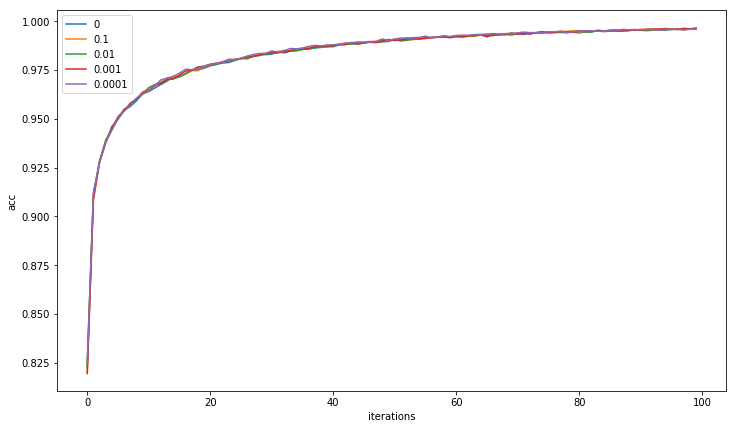

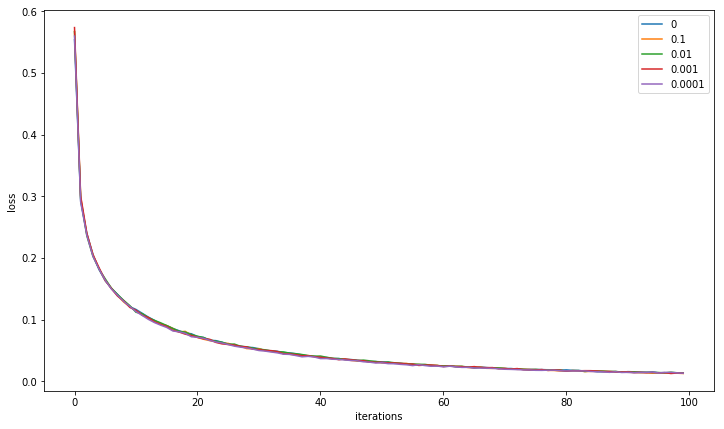

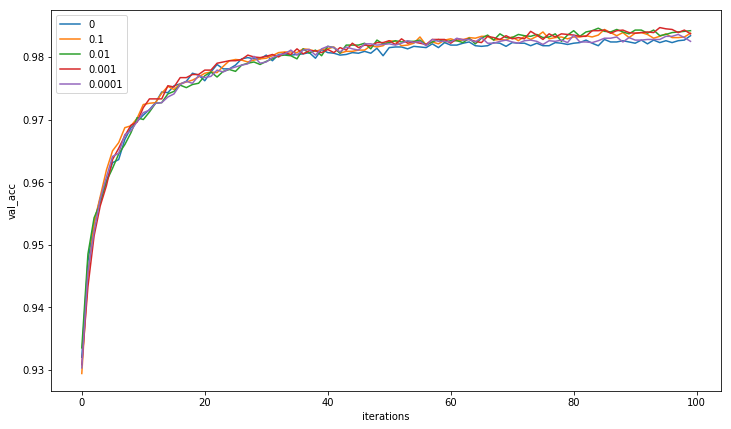

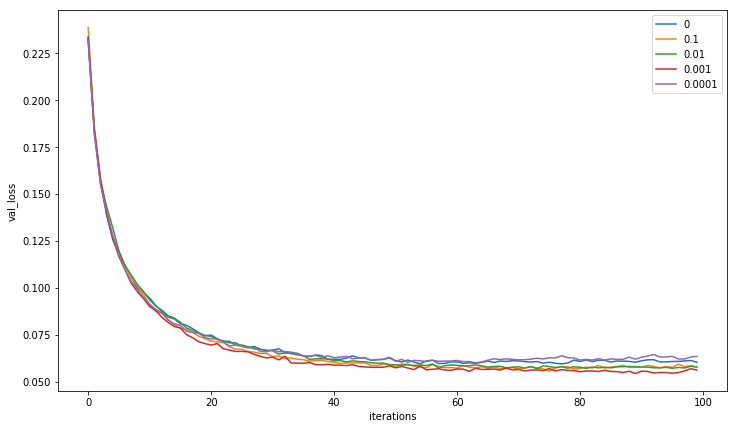

In [73]:
import pandas as pd
logs = {}
for gamma in [0, 0.1, 0.01, 0.001, 0.0001]:
    logs[gamma] = pd.read_csv(f'logs/SGDL_{gamma}.txt', sep=',')

def plot_graphs(column='loss'):
    plt.figure(figsize=(12, 7))
    for g in logs:
        plt.plot(logs[g][column], label=f'{g}')
    plt.xlabel('iterations')
    plt.ylabel(column)
    plt.legend(loc='best')
    plt.show()
    

for column in logs[0].columns:
    if column not in ['epoch']:
        plot_graphs(column)

## Cifar10 training SGD & SGDL

In [128]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

170500096/170498071 [==============================] - 57s 0us/step
X_train original shape (50000, 32, 32, 3)
y_train original shape (50000, 1)


In [129]:
os.makedirs('logs', exist_ok=True)
for gamma in [0, 0.1, 0.01, 0.001, 0.0001]:
    cb = keras.callbacks.CSVLogger(f'logs/SGDL_{gamma}.txt', separator=',')
    model = build_model()
    model.compile(optimizer=SGDL(gamma=gamma), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train,
              batch_size=32, epochs=10,
              verbose=1, callbacks=[cb],
              validation_data=(X_test, y_test))

()
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 141us/step - loss: 2.1040 - acc: 0.2768 - val_loss: 1.7895 - val_acc: 0.3709
Epoch 2/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.8254 - acc: 0.3475 - val_loss: 1.7123 - val_acc: 0.3929
Epoch 3/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.7460 - acc: 0.3786 - val_loss: 1.6520 - val_acc: 0.4154
Epoch 4/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.6965 - acc: 0.3957 - val_loss: 1.6250 - val_acc: 0.4268
Epoch 5/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.6518 - acc: 0.4130 - val_loss: 1.5761 - val_acc: 0.4438
Epoch 6/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.6137 - acc: 0.4224 - val_loss: 1.5752 - val_acc: 0.4429
Epoch 7/10
50000/50000 [==============================] - 5s 103us/step - loss: 1.5910 - acc: 0.4328 - val_loss: 1.5372

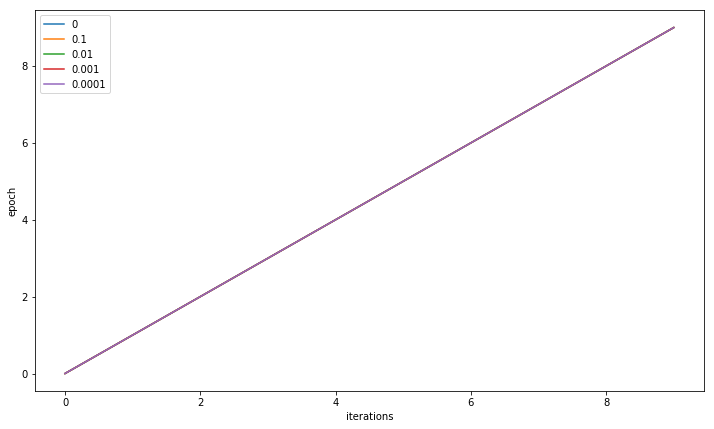

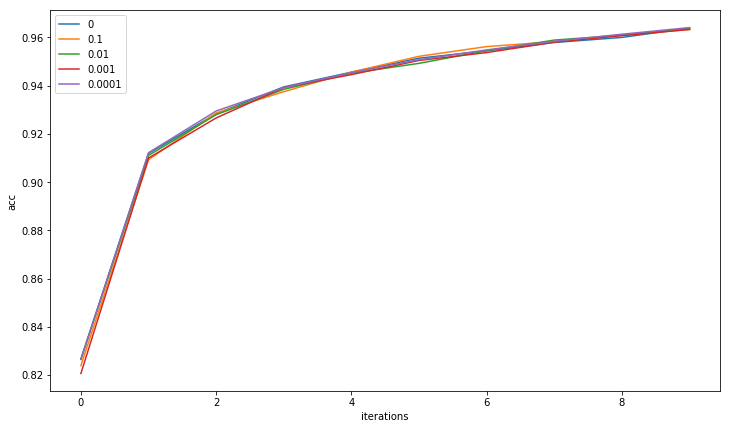

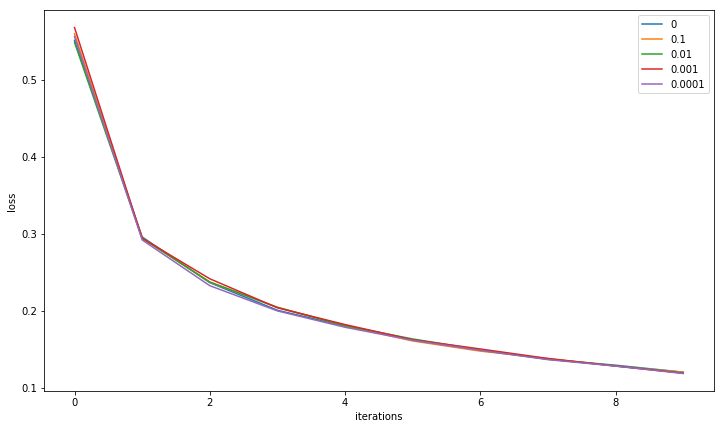

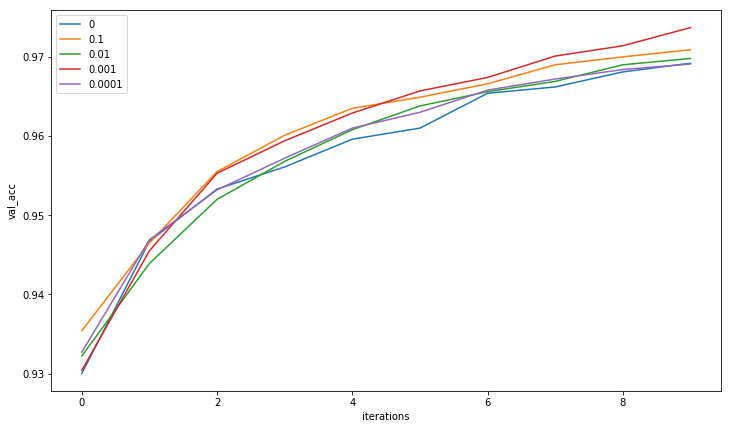

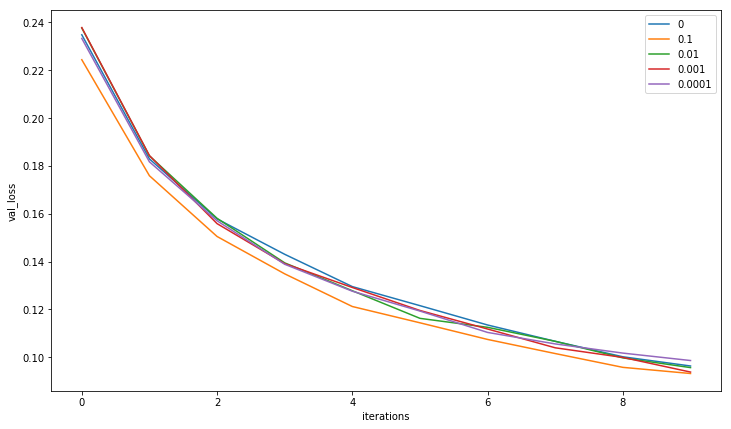

In [71]:
import pandas as pd
logs = {}
for gamma in [0, 0.1, 0.01, 0.001, 0.0001]:
    logs[gamma] = pd.read_csv(f'logs/SGDL_{gamma}.txt', sep=',')

def plot_graphs(column='loss'):
    plt.figure(figsize=(12, 7))
    for g in logs:
        plt.plot(logs[g][column], label=f'{g}')
    plt.xlabel('iterations')
    plt.ylabel(column)
    plt.legend(loc='best')
    plt.show()
    

for column in logs[0].columns:
    if column not in ['epoch']:
        plot_graphs(column)